### Libraries

In [1]:
import tqdm
import time
import numpy as np
from numpy import load
import cv2
from sklearn.metrics import (roc_curve, auc, accuracy_score, f1_score, precision_score, 
                             recall_score, classification_report, confusion_matrix)
from skimage.feature import hog
import seaborn as sn
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from dataio import *
from preprocess import *
from segment import *
from colorfeatures import *
from classify import *
from feature_extraction import *
import xgboost as xgb

In [2]:
import keras
import tensorflow as tf
from keras.layers import *
from keras.preprocessing import image as imag 
from keras.layers import Dropout, Flatten, Dense
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
import matplotlib.pyplot as plt

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.densenet import DenseNet121

from keras.applications.vgg19 import preprocess_input
from keras.applications.vgg16 import preprocess_input
from keras.applications.efficientnet import EfficientNetB0
from keras.applications.efficientnet import EfficientNetB5

import matplotlib.pyplot as plt

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import expand_dims
from matplotlib import pyplot

### Load Dataset

In [6]:
train_data = sortData('C:/Users/30694/Downloads/Melanoma_DeepLearning/siim-isic-melanoma-classification/jpeg/224x224', mask=False,mask_mode='KM')

Number of LES Images: 16491
Number of NV Images: 32542


In [7]:
range(len(train_data))

range(0, 49033)

In [4]:
train_data = dict(list(train_data.items())[:20000])

In [5]:
d=len(train_data)

In [6]:
train_data[15000]

{'id': 'C:/Users/30694/Downloads/Melanoma_DeepLearning/siim-isic-melanoma-classification/jpeg/224x224/malignant\\aug_77_7828',
 'image': 'C:/Users/30694/Downloads/Melanoma_DeepLearning/siim-isic-melanoma-classification/jpeg/224x224/malignant\\aug_77_7828.jpg',
 'label': 1}

In [4]:
val_data   = sortData('C:/Users/30694/Downloads/Melanoma_DeepLearning/siim-isic-melanoma-classification/jpeg/val_images', mask=False,mask_mode='KM')                 # Load Validation Set

Number of LES Images: 141
Number of NV Images: 9662


In [7]:
sample1=plt.imread(r'C:\Users\30694\Desktop\ISIC_0000001.jpg')
s2=plt.imread(r'C:\Users\30694\Desktop\q.png')

In [31]:
s1=cv2.resize(sample1,(224,224))

In [5]:
# Pass Target Images
sample1 = plt.imread('C:/Users/30694/Downloads/Melanoma_DeepLearning/siim-isic-melanoma-classification/jpeg/train_images/benign/ISIC_0170008.jpg')
sample2 = plt.imread('C:/Users/30694/Downloads/Melanoma_DeepLearning/siim-isic-melanoma-classification/jpeg/train_images/benign/ISIC_0155173.jpg')
sample3 = plt.imread('C:/Users/30694/Downloads/Melanoma_DeepLearning/siim-isic-melanoma-classification/jpeg/finalTrain/malignant/ISIC_1069587.jpg')

### Preprocessing

Color Constancy (Gray World, White-Balance, Gray-Edge, Max-RGB)

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x2363bd20bb0>)

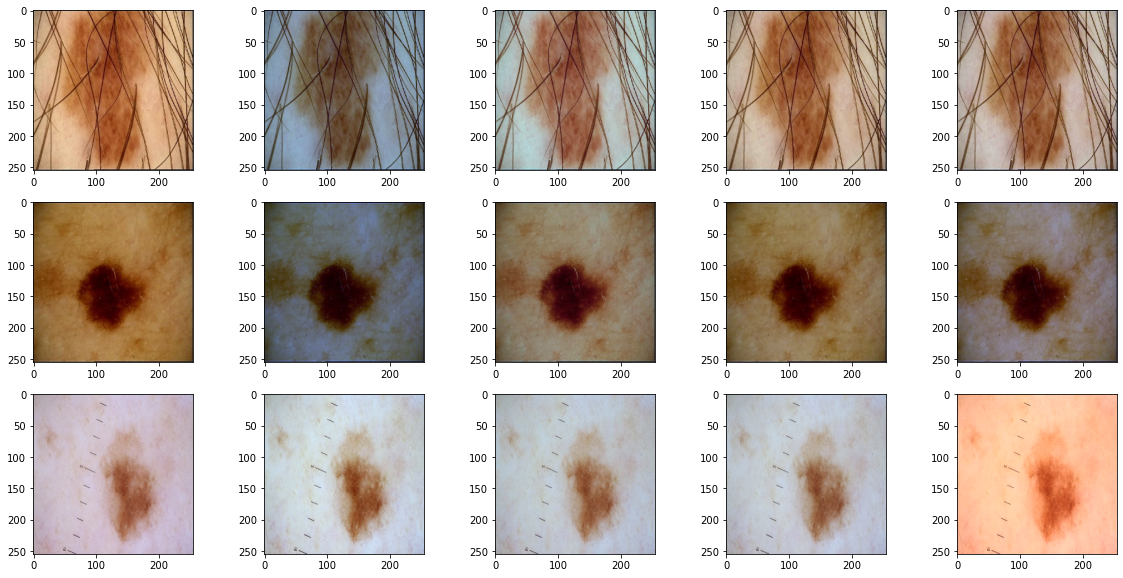

In [6]:
# Color-Constant Transformation
cc1,_ = color_constant(sample1)
cc2,_ = color_constant(sample2)
cc3,_ = color_constant(sample3)

# White-Balance Transformation
wb11 = white_balance(sample1)
wb22 = white_balance(sample2)
wb33 = white_balance(sample3)

# Max-RGB Normalization
mx1 = (correct_image(sample1, grey_edge(sample1, njet=0, mink_norm=-1, sigma=0))*255).astype(np.uint8)
mx2 = (correct_image(sample2, grey_edge(sample2, njet=0, mink_norm=-1, sigma=0))*255).astype(np.uint8)
mx3 = (correct_image(sample3, grey_edge(sample3, njet=0, mink_norm=-1, sigma=0))*255).astype(np.uint8)

# Gray-Edge Color Constancy
ge1 = correct_image(sample1, grey_edge(sample1, njet=1, mink_norm=5, sigma=2))
ge2 = correct_image(sample2, grey_edge(sample2, njet=1, mink_norm=5, sigma=2))
ge3 = correct_image(sample3, grey_edge(sample3, njet=1, mink_norm=5, sigma=2))


plt.figure(figsize=[20,10])
plt.subplot(351),    plt.imshow(sample1)
plt.subplot(352),    plt.imshow(cc1)
plt.subplot(353),    plt.imshow(wb11)
plt.subplot(354),    plt.imshow(mx1)
plt.subplot(355),    plt.imshow(ge1)
plt.subplot(356),    plt.imshow(sample2)
plt.subplot(357),    plt.imshow(cc2)
plt.subplot(358),    plt.imshow(wb22)
plt.subplot(359),    plt.imshow(mx2)
plt.subplot(3,5,10), plt.imshow(ge2)
plt.subplot(3,5,11), plt.imshow(sample3)
plt.subplot(3,5,12), plt.imshow(cc3)
plt.subplot(3,5,13), plt.imshow(wb33)
plt.subplot(3,5,14), plt.imshow(mx3)
plt.subplot(3,5,15), plt.imshow(ge3)

CLAHE Equalization and Occlusion Removal

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x2363cb9a580>)

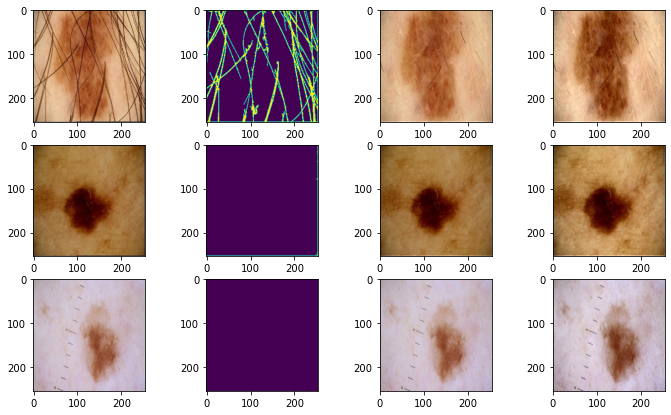

In [7]:
# Occlusion Removal
hr1,mask1 = occlusion_removal(sample1)
hr2,mask2 = occlusion_removal(sample2)
hr3,mask3 = occlusion_removal(sample3)

# White-Balance Transformation
wb1 = white_balance(hr1)
wb2 = white_balance(hr2)
wb3 = white_balance(hr3)

# CLAHE Preprocessing
cl1   = clahe_LAB(hr1)
cl2   = clahe_LAB(hr2)
cl3   = clahe_LAB(hr3)

plt.figure(figsize=[15,7])
plt.subplot(351),    plt.imshow(sample1)
plt.subplot(352),    plt.imshow(mask1)
plt.subplot(353),    plt.imshow(hr1)
#plt.subplot(354),    plt.imshow(wb1)
plt.subplot(354),    plt.imshow(cl1)
plt.subplot(356),    plt.imshow(sample2)
plt.subplot(357),    plt.imshow(mask2)
plt.subplot(358),    plt.imshow(hr2)
#plt.subplot(359),    plt.imshow(wb2)
plt.subplot(359),    plt.imshow(cl2)
plt.subplot(3,5,11),    plt.imshow(sample3)
plt.subplot(3,5,12),    plt.imshow(mask3)
plt.subplot(3,5,13), plt.imshow(hr3)
#plt.subplot(3,5,14), plt.imshow(wb3)
plt.subplot(3,5,14), plt.imshow(cl3)

### Segmentation

Chan-Vese morphological_geodesic_active_contour

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.segmentation import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set,active_contour,inverse_gaussian_gradient)

def segment_l(image):
    image     = img_as_float(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY))
    gimage = inverse_gaussian_gradient(image)

    # Initial level set
    init_ls = np.zeros(image.shape, dtype=np.int8)
    init_ls[10:-10, 10:-10] = 1
    # List with intermediate results for plotting the evolution
    evolution = []
    callback = store_evolution_in(evolution)
    mask = morphological_geodesic_active_contour(gimage, iterations=100,
                                           init_level_set=init_ls,
                                           smoothing=1, balloon=-1,
                                           threshold=0.79,
                                           iter_callback=callback)
    
    return mask

Chan-Vese Active Contours Segmentation

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x2363d0302e0>)

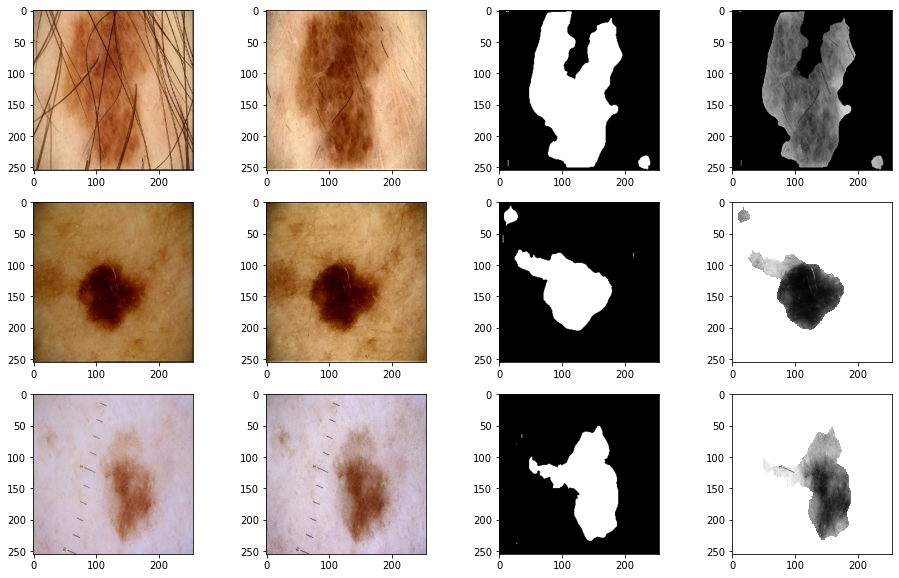

In [9]:
mask1 = segment_l(cl1)
mask2 = segment_l(cl2)
mask3 = segment_l(cl3)

mask1_GL                 = mask1.astype(bool)
img1_GL                  = cv2.cvtColor(cl1, cv2.COLOR_RGB2GRAY) 
lesion1_GL               = np.multiply(img1_GL,mask1_GL)    
compressed_lesion1_GL    = np.ma.array(lesion1_GL,mask=~mask1_GL)
mask2_GL                 = mask2.astype(bool)
img2_GL                  = cv2.cvtColor(cl2, cv2.COLOR_RGB2GRAY) 
lesion2_GL               = np.multiply(img2_GL,mask2_GL)    
compressed_lesion2_GL    = np.ma.array(lesion2_GL,mask=~mask2_GL)
mask3_GL                 = mask3.astype(bool)
img3_GL                  = cv2.cvtColor(cl3, cv2.COLOR_RGB2GRAY) 
lesion3_GL               = np.multiply(img3_GL,mask3_GL)    
compressed_lesion3_GL    = np.ma.array(lesion3_GL,mask=~mask3_GL)

gray_three = cv2.merge([compressed_lesion1_GL,compressed_lesion1_GL,compressed_lesion1_GL])
img = cv2.cvtColor(compressed_lesion1_GL, cv2.COLOR_GRAY2BGR)
img1 = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)

plt.figure(figsize=[16,10])
plt.subplot(341),    plt.imshow(sample1)
plt.subplot(342),    plt.imshow(cl1)
plt.subplot(343),    plt.imshow(mask1,cmap='gray')
plt.subplot(344),    plt.imshow(gray_three)
plt.subplot(345),    plt.imshow(sample2)
plt.subplot(346),    plt.imshow(cl2)
plt.subplot(347),    plt.imshow(mask2,cmap='gray')
plt.subplot(348),    plt.imshow(compressed_lesion2_GL,cmap='gray')
plt.subplot(349),    plt.imshow(sample3)
plt.subplot(3,4,10), plt.imshow(cl3)
plt.subplot(3,4,11), plt.imshow(mask3,cmap='gray')
plt.subplot(3,4,12), plt.imshow(compressed_lesion3_GL,cmap='gray')
    

In [9]:
compressed_lesion1_GL.shape

(255, 255)

Watershed

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x2363f7b9e80>)

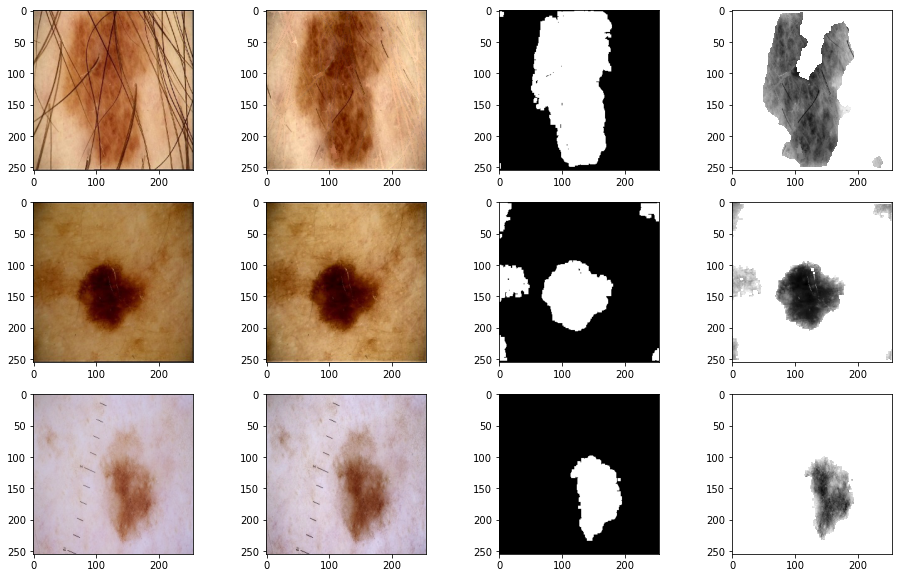

In [10]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
gray1 = cv.cvtColor(cl1,cv.COLOR_BGR2GRAY)
ret1, thresh1 = cv.threshold(gray1,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

# noise removal
kernel1 = np.ones((3,3),np.uint8)
opening1 = cv.morphologyEx(thresh1,cv.MORPH_OPEN,kernel1, iterations = 2)
# sure background area
sure_bg1 = cv.dilate(opening1,kernel1,iterations=3)
# Finding sure foreground area
dist_transform1 = cv.distanceTransform(opening1,cv.DIST_L2,5)
ret1, sure_fg1 = cv.threshold(dist_transform1,0.01*dist_transform1.max(),255,0)

mask2_GL                 = sure_fg1.astype(bool)
img2_GL                  = cv2.cvtColor(cl2, cv2.COLOR_RGB2GRAY) 
lesion2_GL               = np.multiply(img2_GL,mask1_GL)    
compressed_lesion2_GL    = np.ma.array(lesion2_GL,mask=~mask2_GL)

gray2 = cv.cvtColor(cl2,cv.COLOR_BGR2GRAY)
ret2, thresh2 = cv.threshold(gray2,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

# noise removal
kernel2 = np.ones((3,3),np.uint8)
opening2 = cv.morphologyEx(thresh2,cv.MORPH_OPEN,kernel1, iterations = 2)
# sure background area
sure_bg2 = cv.dilate(opening2,kernel2,iterations=3)
# Finding sure foreground area
dist_transform2 = cv.distanceTransform(opening2,cv.DIST_L2,5)
ret2, sure_fg2 = cv.threshold(dist_transform2,0.01*dist_transform2.max(),255,0)

mask2_GL                 = sure_fg2.astype(bool)
img2_GL                  = cv2.cvtColor(cl2, cv2.COLOR_RGB2GRAY) 
lesion2_GL               = np.multiply(img2_GL,mask2_GL)    
compressed_lesion2_GL    = np.ma.array(lesion2_GL,mask=~mask2_GL)

gray3 = cv.cvtColor(cl3,cv.COLOR_BGR2GRAY)
ret3, thresh3 = cv.threshold(gray3,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

# noise removal
kernel3 = np.ones((3,3),np.uint8)
opening3 = cv.morphologyEx(thresh3,cv.MORPH_OPEN,kernel2, iterations = 2)
# sure background area
sure_bg3 = cv.dilate(opening3,kernel3,iterations=3)
# Finding sure foreground area
dist_transform3 = cv.distanceTransform(opening3,cv.DIST_L2,5)
ret3, sure_fg3 = cv.threshold(dist_transform3,0.01*dist_transform3.max(),255,0)

mask3_GL                 = sure_fg3.astype(bool)
img3_GL                  = cv2.cvtColor(cl3, cv2.COLOR_RGB2GRAY) 
lesion3_GL               = np.multiply(img3_GL,mask3_GL)    
compressed_lesion3_GL    = np.ma.array(lesion3_GL,mask=~mask3_GL)

plt.figure(figsize=[16,10])
plt.subplot(341),    plt.imshow(sample1)
plt.subplot(342),    plt.imshow(cl1)
plt.subplot(343),    plt.imshow(sure_fg1,cmap='gray')
plt.subplot(344),    plt.imshow(compressed_lesion1_GL,cmap='gray')
plt.subplot(345),    plt.imshow(sample2)
plt.subplot(346),    plt.imshow(cl2)
plt.subplot(347),    plt.imshow(sure_fg2,cmap='gray')
plt.subplot(348),    plt.imshow(compressed_lesion2_GL,cmap='gray')
plt.subplot(3,4,9),    plt.imshow(sample3)
plt.subplot(3,4,10),    plt.imshow(cl3)
plt.subplot(3,4,11),    plt.imshow(sure_fg3,cmap='gray')
plt.subplot(3,4,12),    plt.imshow(compressed_lesion3_GL,cmap='gray')

Watershed + Sobel

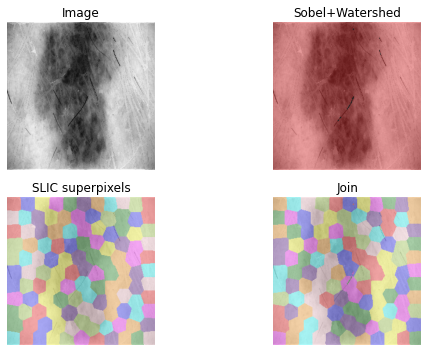

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import sobel
from skimage.measure import label
from skimage.segmentation import slic, join_segmentations, watershed
from skimage.color import label2rgb
from skimage import data

coins = cv2.cvtColor(cl1, cv2.COLOR_RGB2GRAY)

# Make segmentation using edge-detection and watershed.
edges = sobel(coins)

# Identify some background and foreground pixels from the intensity values.
# These pixels are used as seeds for watershed.
markers = np.zeros_like(coins)
foreground, background = 1, 2
markers[coins < 30.0] = background
markers[coins > 150.0] = foreground

ws = watershed(edges, markers)
seg1 = label(ws == foreground)

# Make segmentation using SLIC superpixels.
seg2 = slic(coins, n_segments=117, max_iter=160, sigma=1, compactness=0.75,
             start_label=0)

# Combine the two.
segj = join_segmentations(seg1, seg2)

# Show the segmentations.
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9, 5),
                         sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(coins, cmap='gray')
ax[0].set_title('Image')

color1 = label2rgb(seg1, image=coins, bg_label=0)
ax[1].imshow(color1)
ax[1].set_title('Sobel+Watershed')

color2 = label2rgb(seg2, image=coins, image_alpha=0.5, bg_label=-1)
ax[2].imshow(color2)
ax[2].set_title('SLIC superpixels')

color3 = label2rgb(segj, image=coins, image_alpha=0.5, bg_label=-1)
ax[3].imshow(color3)
ax[3].set_title('Join')

for a in ax:
    a.axis('off')
fig.tight_layout()
plt.show()

Sobel

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x236407670a0>)

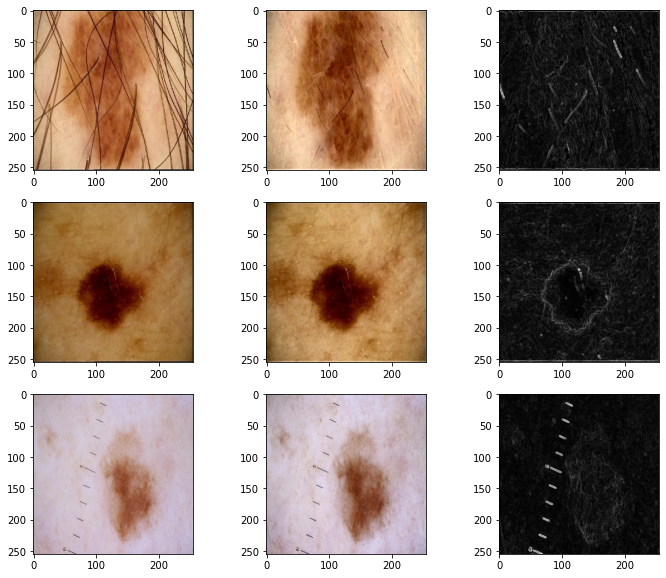

In [12]:
coins1 = cv2.cvtColor(cl1, cv2.COLOR_RGB2GRAY)
coins2 = cv2.cvtColor(cl2, cv2.COLOR_RGB2GRAY)
coins3 = cv2.cvtColor(cl3, cv2.COLOR_RGB2GRAY)

# Make segmentation using edge-detection and watershed.
edges1 = sobel(coins1)
edges2 = sobel(coins2)
edges3 = sobel(coins3)
plt.figure(figsize=[16,10])
plt.subplot(341),    plt.imshow(sample1)
plt.subplot(342),    plt.imshow(cl1)
plt.subplot(343),    plt.imshow(edges1,cmap='gray')
plt.subplot(345),    plt.imshow(sample2)
plt.subplot(346),    plt.imshow(cl2)
plt.subplot(347),    plt.imshow(edges2,cmap='gray')
plt.subplot(349),    plt.imshow(sample3)
plt.subplot(3,4,10), plt.imshow(cl3)
plt.subplot(3,4,11), plt.imshow(edges3,cmap='gray')


KMeans Segmentation

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x23642888400>)

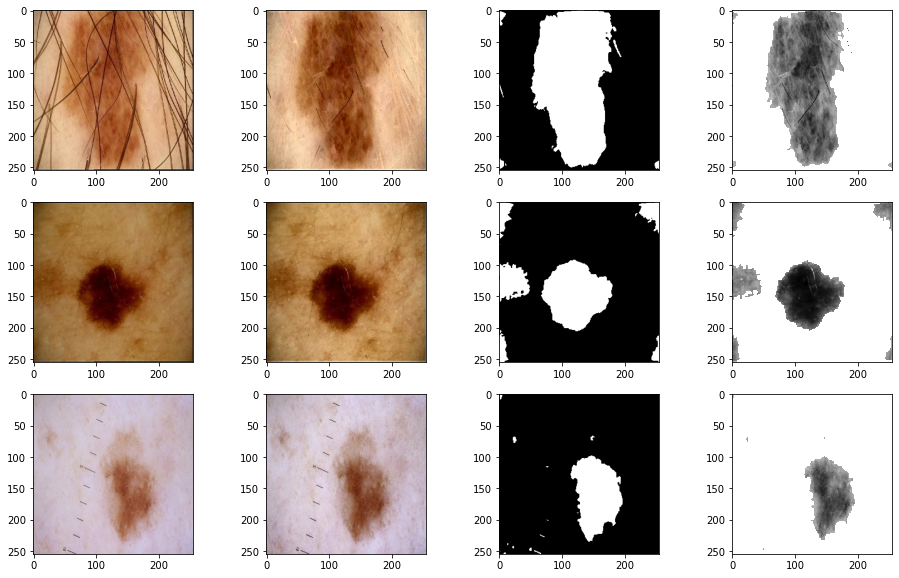

In [13]:
mask1 = segment_lesion(cl1, mode="KMeans")
mask2 = segment_lesion(cl2, mode="KMeans")
mask3 = segment_lesion(cl3, mode="KMeans")

mask1_GL                 = mask1.astype(bool)
img1_GL                  = cv2.cvtColor(cl1, cv2.COLOR_RGB2GRAY) 
lesion1_GL               = np.multiply(img1_GL,mask1_GL)    
compressed_lesion1_GL    = np.ma.array(lesion1_GL,mask=~mask1_GL)
mask2_GL                 = mask2.astype(bool)
img2_GL                  = cv2.cvtColor(cl2, cv2.COLOR_RGB2GRAY) 
lesion2_GL               = np.multiply(img2_GL,mask2_GL)    
compressed_lesion2_GL    = np.ma.array(lesion2_GL,mask=~mask2_GL)
mask3_GL                 = mask3.astype(bool)
img3_GL                  = cv2.cvtColor(cl3, cv2.COLOR_RGB2GRAY) 
lesion3_GL               = np.multiply(img3_GL,mask3_GL)    
compressed_lesion3_GL    = np.ma.array(lesion3_GL,mask=~mask3_GL)

plt.figure(figsize=[16,10])
plt.subplot(341),    plt.imshow(sample1)
plt.subplot(342),    plt.imshow(cl1)
plt.subplot(343),    plt.imshow(mask1,cmap='gray')
plt.subplot(344),    plt.imshow(compressed_lesion1_GL,cmap='gray')
plt.subplot(345),    plt.imshow(sample2)
plt.subplot(346),    plt.imshow(cl2)
plt.subplot(347),    plt.imshow(mask2,cmap='gray')
plt.subplot(348),    plt.imshow(compressed_lesion2_GL,cmap='gray')
plt.subplot(349),    plt.imshow(sample3)
plt.subplot(3,4,10), plt.imshow(cl3)
plt.subplot(3,4,11), plt.imshow(mask3,cmap='gray')
plt.subplot(3,4,12), plt.imshow(compressed_lesion3_GL,cmap='gray')


### Feature Extraction

Hand-Crafted Features Color LBP, Color GLCM, Color Moments

In [14]:
def extract_features(image,mask=None):  
 
    # Color Spaces: I/O ------------------------------------------------------------------------------------------------------------------------------------------------------
    img_RGB               = image
    img_GL                = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2GRAY)
    
    img_HSV               = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2HSV)
    img_LAB               = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2Lab)
    img_YCrCb             = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2YCrCb)
    img_luv               = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2Luv)
    circa_mask            = create_circular_mask(image.shape[0], image.shape[1], radius = 300).astype(bool)
    
    masked_lesion_GL      = np.ma.array(np.multiply(img_GL,    circa_mask)  ,mask=~circa_mask)
    masked_lesion_RGB     = np.ma.array(np.multiply(img_RGB,   np.dstack((circa_mask,circa_mask,circa_mask)))  ,mask=~np.dstack((circa_mask,circa_mask,circa_mask)))
    masked_lesion_HSV     = np.ma.array(np.multiply(img_HSV,   np.dstack((circa_mask,circa_mask,circa_mask)))  ,mask=~np.dstack((circa_mask,circa_mask,circa_mask)))
    masked_lesion_LAB     = np.ma.array(np.multiply(img_LAB,   np.dstack((circa_mask,circa_mask,circa_mask)))  ,mask=~np.dstack((circa_mask,circa_mask,circa_mask)))
    masked_lesion_YCrCb   = np.ma.array(np.multiply(img_YCrCb, np.dstack((circa_mask,circa_mask,circa_mask)))  ,mask=~np.dstack((circa_mask,circa_mask,circa_mask)))
    masked_lesion_luv     = np.ma.array(np.multiply(img_luv,   np.dstack((circa_mask,circa_mask,circa_mask)))  ,mask=~np.dstack((circa_mask,circa_mask,circa_mask)))
    
    
    #-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    

    # Graylevel Co-Occurrence Matrix -------------------------------------------------------------------------------------------------------------------------
    #GLCM_GL    = GLCM(masked_lesion_GL,      channel=1)
    GLCM_RGB   = GLCM(masked_lesion_RGB,     channel=3)
    GLCM_HSV   = GLCM(masked_lesion_HSV,     channel=3)
    GLCM_LAB   = GLCM(masked_lesion_LAB,     channel=3)
    GLCM_YCrCb = GLCM(masked_lesion_YCrCb,   channel=3)
    GLCM_luv   = GLCM(masked_lesion_luv,     channel=3)

    GLCM_CGLF = np.concatenate((GLCM_RGB, GLCM_HSV, GLCM_LAB, GLCM_YCrCb, GLCM_luv),axis=0)
    #----------------------------------------------------------------------------------------------------------------------------------------------------------

    
    # Local Binary Patterns --------------------------------------------------------------------------------------
    lbp_R, lbp_G, lbp_B    = LBP(masked_lesion_RGB,   channel=3)
    lbp_H, lbp_S, lbp_V    = LBP(masked_lesion_HSV,   channel=3)
    lbp_Y, lbp_Cr, lbp_Cb  = LBP(masked_lesion_YCrCb, channel=3)

    LBP_CGLF  = np.concatenate((lbp_R,lbp_G,lbp_B,lbp_H,lbp_S,lbp_V,lbp_Y,lbp_Cr,lbp_Cb),axis=0)
    #--------------------------------------------------------------------------------------------------------------
    
    features = np.concatenate((GLCM_CGLF, LBP_CGLF),axis=0)
    return features

In [15]:
# Feature Vector Length (Redundancy Check)
demo = np.array(extract_features(cl3,np.ones(shape=(cl3.shape[0],cl3.shape[1]))))
print("Feature Vector Shape: "+str(demo.shape))
demo

Feature Vector Shape: (150,)


array([9.65980880e+01, 5.21263207e+00, 9.16006354e-01, 2.35385522e-01,
       9.67846328e+01, 5.24129038e+00, 9.59608052e-01, 2.35686164e-01,
       1.03182311e+02, 5.55216390e+00, 9.75035142e-01, 2.25341494e-01,
       4.98296649e+02, 4.90711764e+00, 9.26978874e-01, 4.93507301e-01,
       2.75981744e+01, 2.74803265e+00, 9.90435754e-01, 4.37459124e-01,
       9.69772198e+01, 5.24405929e+00, 9.20071527e-01, 2.33651394e-01,
       9.30405334e+01, 4.92040444e+00, 9.52065996e-01, 2.52109189e-01,
       7.59781887e-01, 5.25264352e-01, 9.76331852e-01, 7.60505626e-01,
       1.13159856e+00, 6.41192411e-01, 9.92854437e-01, 7.25279981e-01,
       9.63411874e+01, 5.19216747e+00, 9.54359114e-01, 2.39544240e-01,
       1.31936670e+00, 7.48799887e-01, 9.86648633e-01, 6.81100881e-01,
       1.31539132e+00, 7.15725784e-01, 9.89980499e-01, 6.99300075e-01,
       9.36004796e+01, 4.95332509e+00, 9.51831132e-01, 2.50837363e-01,
       9.59843052e-01, 5.96234723e-01, 9.90236408e-01, 7.37034441e-01,
      

'\nplt.figure(figsize=[16,10])\nplt.subplot(341),    plt.imshow(lbp_Y)\n'

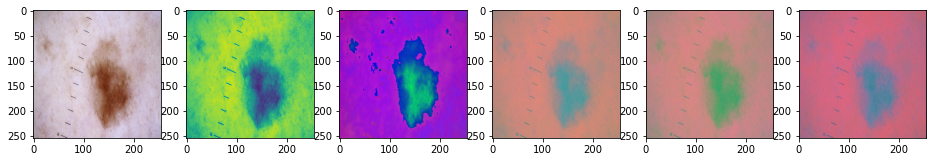

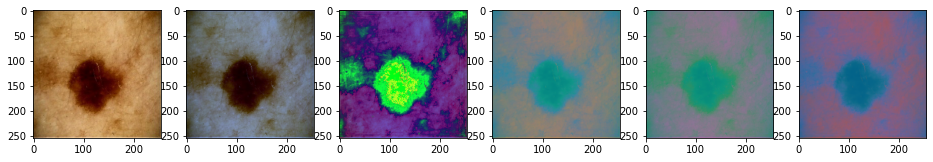

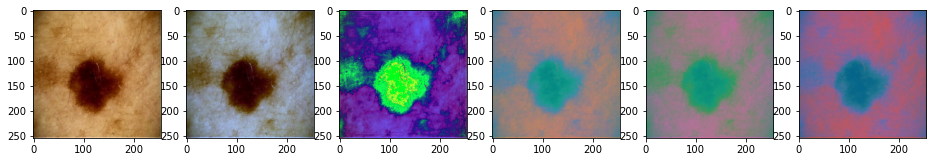

In [18]:

img_RGB               = cl3
img_GL                = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2GRAY)
img_HSV               = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2HSV)
img_LAB               = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2Lab)
img_YCrCb             = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2YCrCb)
img_luv               = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2Luv)
circa_mask            = create_circular_mask(cl1.shape[0], cl3.shape[1], radius = 300).astype(bool)
    
masked_lesion_GL      = np.ma.array(np.multiply(img_GL,    circa_mask)  ,mask=~circa_mask)
masked_lesion_RGB     = np.ma.array(np.multiply(img_RGB,   np.dstack((circa_mask,circa_mask,circa_mask)))  ,mask=~np.dstack((circa_mask,circa_mask,circa_mask)))
masked_lesion_HSV     = np.ma.array(np.multiply(img_HSV,   np.dstack((circa_mask,circa_mask,circa_mask)))  ,mask=~np.dstack((circa_mask,circa_mask,circa_mask)))
masked_lesion_LAB     = np.ma.array(np.multiply(img_LAB,   np.dstack((circa_mask,circa_mask,circa_mask)))  ,mask=~np.dstack((circa_mask,circa_mask,circa_mask)))
masked_lesion_YCrCb   = np.ma.array(np.multiply(img_YCrCb, np.dstack((circa_mask,circa_mask,circa_mask)))  ,mask=~np.dstack((circa_mask,circa_mask,circa_mask)))
masked_lesion_luv     = np.ma.array(np.multiply(img_luv,   np.dstack((circa_mask,circa_mask,circa_mask)))  ,mask=~np.dstack((circa_mask,circa_mask,circa_mask)))


# Color Constancy Spaces: I/O ---------------------------------------------------------------------------------------------------------------------------------------------
img_ccRGB,_           = color_constant(cl2)
img_ccGL              = cv2.cvtColor(img_ccRGB, cv2.COLOR_RGB2GRAY)
img_ccHSV             = cv2.cvtColor(img_ccRGB, cv2.COLOR_RGB2HSV)
img_ccLAB             = cv2.cvtColor(img_ccRGB, cv2.COLOR_RGB2Lab)
img_ccYCrCb           = cv2.cvtColor(img_ccRGB, cv2.COLOR_RGB2YCrCb)
img_ccluv             = cv2.cvtColor(img_ccRGB, cv2.COLOR_RGB2Luv)

masked_lesion_ccGL    = np.ma.array(np.multiply(img_ccGL,    circa_mask)  ,mask=~circa_mask)
masked_lesion_ccRGB   = np.ma.array(np.multiply(img_ccRGB,   np.dstack((circa_mask,circa_mask,circa_mask)))  ,mask=~np.dstack((circa_mask,circa_mask,circa_mask)))
masked_lesion_ccHSV   = np.ma.array(np.multiply(img_ccHSV,   np.dstack((circa_mask,circa_mask,circa_mask)))  ,mask=~np.dstack((circa_mask,circa_mask,circa_mask)))
masked_lesion_ccLAB   = np.ma.array(np.multiply(img_ccLAB,   np.dstack((circa_mask,circa_mask,circa_mask)))  ,mask=~np.dstack((circa_mask,circa_mask,circa_mask)))
masked_lesion_ccYCrCb = np.ma.array(np.multiply(img_ccYCrCb, np.dstack((circa_mask,circa_mask,circa_mask)))  ,mask=~np.dstack((circa_mask,circa_mask,circa_mask)))
masked_lesion_ccluv   = np.ma.array(np.multiply(img_ccluv,   np.dstack((circa_mask,circa_mask,circa_mask)))  ,mask=~np.dstack((circa_mask,circa_mask,circa_mask)))

    
img_mxRGB             = (correct_image(cl2, grey_edge(cl2, njet=0, mink_norm=1, sigma=0))*255).astype(np.uint8)
img_mxGL              = cv2.cvtColor(img_mxRGB, cv2.COLOR_RGB2GRAY)
img_mxHSV             = cv2.cvtColor(img_mxRGB, cv2.COLOR_RGB2HSV)
img_mxLAB             = cv2.cvtColor(img_mxRGB, cv2.COLOR_RGB2Lab)
img_mxYCrCb           = cv2.cvtColor(img_mxRGB, cv2.COLOR_RGB2YCrCb)
img_mxluv             = cv2.cvtColor(img_mxRGB, cv2.COLOR_RGB2Luv)
   
masked_lesion_mxGL    = np.ma.array(np.multiply(img_mxGL,    circa_mask)  ,mask=~circa_mask)
masked_lesion_mxRGB   = np.ma.array(np.multiply(img_mxRGB,   np.dstack((circa_mask,circa_mask,circa_mask)))  ,mask=~np.dstack((circa_mask,circa_mask,circa_mask)))
masked_lesion_mxHSV   = np.ma.array(np.multiply(img_mxHSV,   np.dstack((circa_mask,circa_mask,circa_mask)))  ,mask=~np.dstack((circa_mask,circa_mask,circa_mask)))
masked_lesion_mxLAB   = np.ma.array(np.multiply(img_mxLAB,   np.dstack((circa_mask,circa_mask,circa_mask)))  ,mask=~np.dstack((circa_mask,circa_mask,circa_mask)))
masked_lesion_mxYCrCb = np.ma.array(np.multiply(img_mxYCrCb, np.dstack((circa_mask,circa_mask,circa_mask)))  ,mask=~np.dstack((circa_mask,circa_mask,circa_mask)))
masked_lesion_mxluv   = np.ma.array(np.multiply(img_mxluv,   np.dstack((circa_mask,circa_mask,circa_mask)))  ,mask=~np.dstack((circa_mask,circa_mask,circa_mask)))

mask_test=segment_lesion(cl1,mode='EM')
mask_GL                 = mask_test.astype(bool)
img_GL                  = cv2.cvtColor(cl1, cv2.COLOR_RGB2GRAY) 
lesion3_GL               = np.multiply(img_GL,mask_GL)    
compressed_les    = np.ma.array(lesion3_GL,mask=~mask_GL)


GLCM_RGB   = GLCM(compressed_les,   channel=1)
GLCM_HSV   = GLCM(masked_lesion_HSV,   channel=3)
GLCM_LAB   = GLCM(masked_lesion_LAB,   channel=3)  

# Color Markers ----------------------------------------------------------------------------------------------------------------
CM_black, CM_red, CM_bluegray, CM_white, CM_lightbrown, CM_darkbrown = melanoma_color_markers(masked_lesion_RGB, circa_mask)  
#-------------------------------------------------------------------------------------------------------------------------------
    
    
# Local Binary Patterns --------------------------------------------------------------------------------------
lbp_R, lbp_G, lbp_B    = LBP(masked_lesion_RGB,   channel=3)
lbp_H, lbp_S, lbp_V    = LBP(masked_lesion_HSV,   channel=3)
lbp_Y, lbp_Cr, lbp_Cb  = LBP(masked_lesion_YCrCb, channel=3)
LBP_CGLF  = np.concatenate((lbp_R,lbp_G,lbp_B,lbp_H,lbp_S,lbp_V,lbp_Y,lbp_Cr,lbp_Cb),axis=0)
#------------------------------------------------------------------------------------------------
'''
plt.figure(figsize=[16,10])
plt.subplot(341),    plt.imshow(img_RGB,cmap='gray')
plt.subplot(342),    plt.imshow(img_GL,cmap='gray')
plt.subplot(343),    plt.imshow(img_HSV,cmap='gray')
plt.subplot(344),    plt.imshow(img_LAB,cmap='gray')
plt.subplot(345),    plt.imshow(img_YCrCb,cmap='gray')
plt.subplot(346),    plt.imshow(img_luv,cmap='gray')
'''

plt.figure(figsize=[16,10])

#plt.subplot(341),    plt.imshow(sample3)
plt.subplot(361),    plt.imshow(cl3)
plt.subplot(362),    plt.imshow(masked_lesion_GL)
plt.subplot(363),    plt.imshow(masked_lesion_HSV)
plt.subplot(364),    plt.imshow(masked_lesion_LAB)
plt.subplot(365),    plt.imshow(masked_lesion_YCrCb)
plt.subplot(366),    plt.imshow(masked_lesion_luv)
'''
plt.figure(figsize=[16,10])
plt.subplot(341),    plt.imshow(img_ccRGB)
plt.subplot(342),    plt.imshow(img_ccGL)
plt.subplot(343),    plt.imshow(img_ccHSV)
plt.subplot(344),    plt.imshow(img_ccLAB)
plt.subplot(345),    plt.imshow(img_ccYCrCb)
plt.subplot(346),    plt.imshow(img_ccluv)
'''
plt.figure(figsize=[16,10])
plt.subplot(361),    plt.imshow(cl2)
plt.subplot(362),    plt.imshow(masked_lesion_ccRGB)
plt.subplot(363),    plt.imshow(masked_lesion_ccHSV)
plt.subplot(364),    plt.imshow(masked_lesion_ccLAB)
plt.subplot(365),    plt.imshow(masked_lesion_ccYCrCb)
plt.subplot(366),    plt.imshow(masked_lesion_ccluv)
'''
plt.figure(figsize=[16,10])
plt.subplot(341),    plt.imshow(img_mxRGB)
plt.subplot(342),    plt.imshow(img_mxGL)
plt.subplot(343),    plt.imshow(img_mxHSV)
plt.subplot(344),    plt.imshow(img_mxLAB)
plt.subplot(345),    plt.imshow(img_mxYCrCb)
plt.subplot(346),    plt.imshow(img_mxluv)
'''
plt.figure(figsize=[16,10])
plt.subplot(361),    plt.imshow(cl2)
plt.subplot(362),    plt.imshow(masked_lesion_mxRGB)
plt.subplot(363),    plt.imshow(masked_lesion_mxHSV)
plt.subplot(364),    plt.imshow(masked_lesion_mxLAB)
plt.subplot(365),    plt.imshow(masked_lesion_mxYCrCb)
plt.subplot(366),    plt.imshow(masked_lesion_mxluv)

'''
plt.figure(figsize=[16,10])
plt.subplot(341),    plt.imshow(lbp_Y)
'''




In [9]:
def extract(image):
    #G = GLCM(image,channel=3)
    L = LBP(image,channel=3)

   # m  = np.concatenate((G, L),axis = 0)
    return L

In [23]:
def segment_le(image):
    gray1 = cv.cvtColor(cl1,cv.COLOR_BGR2GRAY)
    ret1, thresh1 = cv.threshold(gray1,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

    # noise removal
    kernel1 = np.ones((3,3),np.uint8)
    opening1 = cv.morphologyEx(thresh1,cv.MORPH_OPEN,kernel1, iterations = 2)
    # sure background area
    sure_bg1 = cv.dilate(opening1,kernel1,iterations=3)
    # Finding sure foreground area
    dist_transform1 = cv.distanceTransform(opening1,cv.DIST_L2,5)
    ret1, sure_fg1 = cv.threshold(dist_transform1,0.01*dist_transform1.max(),255,0)

    mask2_GL                 = sure_fg1.astype(bool)
    img2_GL                  = cv2.cvtColor(cl2, cv2.COLOR_RGB2GRAY) 
    lesion2_GL               = np.multiply(img2_GL,mask1_GL)    
    compressed_lesion2_GL    = np.ma.array(lesion2_GL,mask=~mask2_GL)
    return compressed_lesion2_GL

In [29]:
def seg_les(image):
    coins = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edges = sobel(coins)
    return edges

In [6]:
model = keras.models.load_model(r'C:\Users\30694\Desktop\melanoma_segmentation_Unet\weight11111.h5')

In [7]:
from numpy import array
from PIL import Image
def unet(image):
    img = np.reshape(image,[1,224,224,3])
    preds=model.predict(img)
    image = array(preds).reshape(1, 224 * 224 * 3)
    image = array(image).reshape(224,224,3)
    #img = Image.fromarray(image, 'RGB')

    return image


Training -Validation Hand-Crafted Features

In [10]:
train_hand_crafted_features_les = [] 
train_hand_crafted_features_nv  = []

counter      = 0
start        = 0
stop         = len(train_data)

for index in tqdm.tqdm(range(start,stop)):
    time.sleep(0.01)

    # Load Dataset
    image    = plt.imread(train_data[index]['image'])
    scan_id  = train_data[index]['id']
    label    = train_data[index]['label']
        
    # External Preprocessing 
    hr,_     = occlusion_removal(image)       # Occlusion Removal
    cl       = clahe_LAB(hr)                  # CLAHE Preprocessing
    
    '''
    # Segmentation 
    mask                     = segment_l(cl)
    mask_GL                  = mask.astype(bool)
    img_GL                  = cv2.cvtColor(cl, cv2.COLOR_RGB2GRAY) 
    lesion_GL                = np.multiply(img_GL,mask_GL)    
    compressed_lesion_GL     = np.ma.array(lesion_GL,mask=~mask_GL)
    image                   = cv2.cvtColor(compressed_lesion_GL, cv2.COLOR_GRAY2RGB)
    '''
    #seg = segment_lesion(cl, mode="KMeans")
    seg  = unet(image)
    features = extract(seg)
    features = np.expand_dims(np.asarray(features),axis=0)

    
    # Feature Extraction
    #features = extract_features(image)
    #features = np.expand_dims(np.asarray(features),axis=0)
    
    # Pass to Feature Vectors
    if (label==1):                           # LES Features
        if (len(train_hand_crafted_features_les)==0):
            train_hand_crafted_features_les = features
        else:
            train_hand_crafted_features_les = np.concatenate((train_hand_crafted_features_les,features),axis=0)
    if (label==0):                           # NV Features
        if (len(train_hand_crafted_features_nv)==0):
            train_hand_crafted_features_nv = features
        else:
            train_hand_crafted_features_nv = np.concatenate((train_hand_crafted_features_nv,features),axis=0)
    counter = counter + 1

print("Features Extraction (Training Set) Complete: "+str(counter))

100%|██████████| 49033/49033 [1:39:28<00:00,  8.21it/s]  

Features Extraction (Training Set) Complete: 49033


In [11]:
np.save('unet_hc_features_les.npy', train_hand_crafted_features_les)
np.save('unet_hc_features_nv.npy', train_hand_crafted_features_nv)

In [12]:
hc_les = load('kmeans_hc_features_les.npy', allow_pickle=True)

In [13]:
hc_les.shape

(16491, 14)

In [37]:
val_hand_crafted_features_les = [] 
val_hand_crafted_features_nv  = []

counter      = 0
start        = 0
stop         = len(val_data)

for index in tqdm.tqdm(range(start,stop)):
    time.sleep(0.01)

    # Load Dataset
    image    = plt.imread(val_data[index]['image'])
    scan_id  = val_data[index]['id']
    label    = val_data[index]['label']
    
   # External Preprocessing (Discontinued)
    hr,_     = occlusion_removal(image)       # Occlusion Removal
    cl       = clahe_LAB(hr)                  # CLAHE Preprocessing
    '''
    # Segmentation (Discontinued)
    mask                     = segment_l(cl)
    mask_GL                  = mask.astype(bool)
    img_GL                  = cv2.cvtColor(cl, cv2.COLOR_RGB2GRAY) 
    lesion_GL                = np.multiply(img_GL,mask1_GL)    
    compressed_lesion_GL     = np.ma.array(lesion_GL,mask=~mask_GL)
    image                   = cv2.cvtColor(compressed_lesion_GL, cv2.COLOR_GRAY2RGB)
    # Feature Extraction
    features = extract_features(image)
    features = np.expand_dims(np.asarray(features),axis=0)
    
   
    # Segmentation (Discontinued)
    #mask     = segment_lesion(cl, mode="active_contours")   
    #mask     = (plt.imread(train_data[index]['mask'])).astype(bool)
    '''
    # Feature Extraction
    features = extract_features(image)
    features = np.expand_dims(np.asarray(features),axis=0)
    
    # Pass to Feature Vectors
    if (label==1):                           # LES Features
        if (len(val_hand_crafted_features_les)==0):
            val_hand_crafted_features_les = features
        else:
            val_hand_crafted_features_les = np.concatenate((val_hand_crafted_features_les,features),axis=0)
    if (label==0):                           # NV Features
        if (len(val_hand_crafted_features_nv)==0):
            val_hand_crafted_features_nv = features
        else:
            val_hand_crafted_features_nv = np.concatenate((val_hand_crafted_features_nv,features),axis=0)
    counter = counter + 1

print("Features Extraction (Validation Set) Complete: "+str(counter))

100%|██████████| 9803/9803 [1:34:47<00:00,  1.72it/s]

Features Extraction (Validation Set) Complete: 9803


CNN Features

In [ ]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), input_shape=(255, 255, 3), padding='VALID'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='VALID'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model.add(Conv2D(128, kernel_size=(3, 3), strides=1, activation='relu', padding='VALID'))
model.add(Conv2D(128, kernel_size=(3, 3), strides=1, activation='relu', padding='VALID'))
model.add(AveragePooling2D(pool_size=(19, 19)))

# set of FC => RELU layers
model.add(Flatten())

#getting the summary of the model (architecture)
model.summary()

Training - Validation CNN features

In [ ]:
train_cnn_features_les = [] 
train_cnn_features_nv  = []

counter      = 0
start        = 0
stop         = len(train_data)

for index in tqdm.tqdm(range(start,stop)):
    time.sleep(0.01)

    # Load Dataset
    im       = plt.imread(train_data[index]['image'])
    scan_id  = train_data[index]['id']
    label    = train_data[index]['label']
        
    # External Preprocessing 
    hr,_     = occlusion_removal(im)       # Occlusion Removal
    cl       = clahe_LAB(hr)                  # CLAHE Preprocessing
    
    img      = cl
    img_data = imag.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    features = model.predict(img_data)
   
    # Pass to Feature Vectors
    if (label==1):                           # LES Features
        if (len(train_cnn_features_les)==0):
            train_cnn_features_les = features
        else:
            train_cnn_features_les = np.concatenate((train_cnn_features_les,features),axis=0)
    if (label==0):                           # NV Features
        if (len(train_cnn_features_nv)==0):
            train_cnn_features_nv = features
        else:
            train_cnn_features_nv = np.concatenate((train_cnn_features_nv,features),axis=0)
    counter = counter + 1

print("Features Extraction (Training Set) Complete: "+str(counter))

In [ ]:
val_cnn_features_les = [] 
val_cnn_features_nv  = []

counter      = 0
start        = 0
stop         = len(val_data)

for index in tqdm.tqdm(range(start,stop)):
    time.sleep(0.01)

    # Load Dataset
    im    = plt.imread(val_data[index]['image'])
    scan_id  = val_data[index]['id']
    label    = val_data[index]['label']
    
   # External Preprocessing 
    hr,_     = occlusion_removal(im)       # Occlusion Removal
    cl       = clahe_LAB(hr)                  # CLAHE Preprocessing
    
    img      = cl
    img_data = imag.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    features = model.predict(img_data)
    
    # Pass to Feature Vectors
    if (label==1):                           # LES Features
        if (len(val_cnn_features_les)==0):
            val_cnn_features_les = features
        else:
            val_cnn_features_les = np.concatenate((val_cnn_features_les,features),axis=0)
    if (label==0):                           # NV Features
        if (len(val_cnn_features_nv)==0):
            val_cnn_features_nv = features
        else:
            val_cnn_features_nv = np.concatenate((val_cnn_features_nv,features),axis=0)
    counter = counter + 1

print("Features Extraction (Validation Set) Complete: "+str(counter))

In [ ]:
np.save('aug_train_cnn_features_les.npy', train_cnn_features_les)
np.save('aug_train_cnn_features_nv.npy', train_cnn_features_nv)
np.save('val_cnn_features_les.npy', val_cnn_features_les)
np.save('val_cnn_features_nv.npy', val_cnn_features_nv)

In [52]:
from numpy import load
vgg_les = load('aug_train_cnn_features_les.npy', allow_pickle=True)
vgg_nv = load('aug_train_cnn_features_nv.npy', allow_pickle=True)
meta_les = load('aug_train_metadata_features_les.npy', allow_pickle=True)
meta_nv = load('aug_train_metadata_features_nv.npy', allow_pickle=True)
hc_les = load('aug_train_hand_crafted_features_les.npy', allow_pickle=True)
hc_nv = load('aug_train_hand_crafted_features_nv.npy', allow_pickle=True)


VGG16 features

In [53]:
vgg_les.shape

(16346, 4608)

In [3]:
SIZE=224
base_model = VGG19(weights='imagenet', include_top=True, input_shape=(SIZE, SIZE, 3))
base_model.summary()


574726144/574710816 [==============================] - 24s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

In [5]:
SIZE=224
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))
base_model.summary()
#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
#for layer in VGG_model.layers:
#	layer.trainable = False
    
model= Sequential()
model.add(base_model) 
model.add(Flatten())
model.add(Dense(4096,activation=('relu')))

#Model summary
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [5]:
VGG_16_pre_trained= VGG16( include_top=True, weights='imagenet', input_tensor=None,input_shape=(224, 224, 3), pooling='max', classes=1000,classifier_activation='softmax') #Line 1
print(VGG_16_pre_trained.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Visualize VGG16 weights

In [28]:
model = DenseNet121()
filters,biases = model.layers[2].get_weights()
f_min, f_max = filters.min(),filters.max()
filters = (filters - f_min) / (f_max - f_min)
f_min, f_max = filters.min(),filters.max()
filters = (filters - f_min) / (f_max - f_min)
n_filters,ix=6,1
for i in range(n_filters):
    f = filters[:,:,:,i]
    for j in range (3):
        ax = pyplot.subplot(n_filters,3,ix)
        ax.set_xticks([])
        ax.set_yticks([])
        pyplot.imshow(f[:,:,j], cmap='gray')
        ix+=1
pyplot.show()

ValueError: not enough values to unpack (expected 2, got 1)

In [31]:
densenet = DenseNet121()
w0 = densenet.layers[2].get_weights()
w = model.layers[2].get_weights()
w[0][:, :, [0, 1, 2], :] = 0.9 * w0[0][:, :, :3, :]
w[0][:, :, 3, :] = 0.1 * w0[0][:, :, 1, :]
model.layers[2].set_weights(w)
for i in range(3, len(densenet.layers)):
    model.layers[i].set_weights(densenet.layers[i].get_weights())
    model.layers[i].trainable = False

IndexError: index 3 is out of bounds for axis 2 with size 3

VGG16 Architecture

In [ ]:
for i in range (len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue
    print(i,layer.name,layer.output.shape)

In [46]:
model = EfficientNetB0()
ixs = [2,5,9,13,17]
outputs=[model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs,outputs=outputs)



img = load_img(r'C:\Users\30694\Downloads\Melanoma_DeepLearning\siim-isic-melanoma-classification\jpeg\train_images\benign\ISIC_0086349.jpg' , target_size=(224,224))

img = img_to_array(img)
img = expand_dims(img,axis=0)
img = preprocess_input(img)
feature_maps = model.predict(img)
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, feature_maps):print(f"The shape of the {layer_name} is =======>> {feature_map.shape}")
'''
square = 8
for fmap in feature_maps:
    ix=1
    for _ in range(square):
        for _ in range(square):
            ax = pyplot.subplot(square,square,ix)
            ax.set_xticks([])
            ax.set_yticks([])
            pyplot.imshow(fmap[0,:,:,ix-1], cmap='gray')
            ix+=1
    pyplot.show()
'''

The shape of the input_24 is =======>> (1, 224, 224, 3)
The shape of the rescaling_11 is =======>> (1, 112, 112, 32)
The shape of the normalization_11 is =======>> (1, 112, 112, 32)
The shape of the stem_conv_pad is =======>> (1, 1, 1, 32)
The shape of the stem_conv is =======>> (1, 112, 112, 96)


"\nsquare = 8\nfor fmap in feature_maps:\n    ix=1\n    for _ in range(square):\n        for _ in range(square):\n            ax = pyplot.subplot(square,square,ix)\n            ax.set_xticks([])\n            ax.set_yticks([])\n            pyplot.imshow(fmap[0,:,:,ix-1], cmap='gray')\n            ix+=1\n    pyplot.show()\n"

In [55]:
for layer_name, feature_map in zip(layer_names, feature_maps):   
    if len(feature_map.shape) == 4:# Number of feature images/dimensions in a feature map of a layer 
        k = feature_map.shape[-1]  
  
    #iterating over a feature map of a particular layer to separate all feature images.    
    for i in range(k):
        feature_image = feature_map[0, :, :, i]

In [62]:
for layer_name, feature_map in zip(layer_names, feature_maps):  
    if len(feature_map.shape) == 4:
        k = feature_map.shape[-1]  
        size=feature_map.shape[1]
        for i in range(k):
            feature_image = feature_map[0, :, :, i]
            feature_image-= feature_image.mean()
            feature_image/= feature_image.std ()
            feature_image*=  64
            feature_image+= 128
            feature_image= np.clip(0, 0, 255).astype('uint8')
            image_belt[:, i * size : (i + 1) * size] = feature_image 

TypeError: 'int' object does not support item assignment

Training - Validation VGG16 features

In [8]:
train_features_les = [] 
train_features_nv  = []

counter      = 0
start        = 0
stop         = len(train_data)

for index in tqdm.tqdm(range(start,stop)):
    time.sleep(0.01)

    # Load Dataset
    im       = plt.imread(train_data[index]['image'])
    scan_id  = train_data[index]['id']
    label    = train_data[index]['label']
        
    # External Preprocessing 
    hr,_     = occlusion_removal(im)       # Occlusion Removal
    cl       = clahe_LAB(hr)                  # CLAHE Preprocessing
    
    img      = cl
    img_data = imag.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    features = model.predict(img_data)
    #features = feature_extractor.reshape(feature_extractor.shape[0], -1)
   
    # Pass to Feature Vectors
    if (label==1):                           # LES Features
        if (len(train_features_les)==0):
            train_features_les = features
        else:
            train_features_les = np.concatenate((train_features_les,features),axis=0)
    if (label==0):                           # NV Features
        if (len(train_features_nv)==0):
            train_features_nv = features
        else:
            train_features_nv = np.concatenate((train_features_nv,features),axis=0)
    counter = counter + 1

print("Features Extraction (Training Set) Complete: "+str(counter))

  0%|          | 0/49033 [00:00<?, ?it/s]

In [10]:
np.save('p5_vgg16_features_les.npy', train_features_les)
np.save('p5_vgg16_features_nv.npy', train_features_nv)

In [3]:
'''
ef_les_1 = load('effNet_les_part1.npy', allow_pickle=True)
ef_les_2 = load('effNet_les_part2.npy', allow_pickle=True)
ef_les_3 = load('effNet_les_part3.npy', allow_pickle=True)
ef_les_4 = load('effNet_les_part4.npy', allow_pickle=True)

'''
ef_nv_4 = load('effNet_nv_part4.npy', allow_pickle=True)
ef_nv_5 = load('effNet_nv_part5.npy', allow_pickle=True)
ef_nv_6 = load('effNet_nv_part6.npy', allow_pickle=True)
ef_nv_7 = load('effNet_nv_part7.npy', allow_pickle=True)
ef_nv_8 = load('effNet_nv_part8.npy', allow_pickle=True)



In [8]:
ef_nv_4 = load('p1_vgg19_features_les.npy', allow_pickle=True)


In [9]:
ef_nv_4.shape

(16491, 25088)

In [4]:
ef_nv = np.concatenate((ef_nv_4,ef_nv_5,ef_nv_6,ef_nv_7, ef_nv_8),axis=0)


In [5]:
np.save('effNetB0_nv.npy', ef_nv)
#np.save('vgg16_224x224_les.npy', vgg16_les)

In [6]:
SIZE=224
VGG_model = VGG19(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False
    
VGG_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [11]:
d

29033

In [13]:
train_features_les = [] 
train_features_nv  = []

counter      = 0
start        = 20000
stop         = 49033

for index in tqdm.tqdm(range(start,stop)):
    time.sleep(0.01)

    # Load Dataset
    im       = plt.imread(train_data[index]['image'])
    scan_id  = train_data[index]['id']
    label    = train_data[index]['label']
        
    # External Preprocessing 
    hr,_     = occlusion_removal(im)       # Occlusion Removal
    cl       = clahe_LAB(hr)                  # CLAHE Preprocessing
    
    img      = cl
    img_data = imag.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    feature_extractor = VGG_model.predict(img_data)
    features = feature_extractor.reshape(feature_extractor.shape[0], -1)
   
    # Pass to Feature Vectors
    if (label==1):                           # LES Features
        if (len(train_features_les)==0):
            train_features_les = features
        else:
            train_features_les = np.concatenate((train_features_les,features),axis=0)
    if (label==0):                           # NV Features
        if (len(train_features_nv)==0):
            train_features_nv = features
        else:
            train_features_nv = np.concatenate((train_features_nv,features),axis=0)
    counter = counter + 1

print("Features Extraction (Training Set) Complete: "+str(counter))

100%|██████████| 29033/29033 [6:22:35<00:00,  1.26it/s]  

Features Extraction (Training Set) Complete: 29033


In [14]:
np.save('p2_vgg19_features_les.npy', train_features_les)
np.save('p2_vgg19_features_nv.npy', train_features_nv)

In [23]:
SIZE=224
Dense_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in Dense_model.layers:
	layer.trainable = False
    
Dense_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [9]:
train_features_les = [] 
train_features_nv  = []

counter      = 0
start        = 0
stop         = len(train_data)

for index in tqdm.tqdm(range(start,stop)):
    time.sleep(0.01)

    # Load Dataset
    im       = plt.imread(train_data[index]['image'])
    scan_id  = train_data[index]['id']
    label    = train_data[index]['label']
        
    # External Preprocessing 
    hr,_     = occlusion_removal(im)       # Occlusion Removal
    cl       = clahe_LAB(hr)                  # CLAHE Preprocessing
    
    img      = cl
    img_data = imag.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    feature_extractor = Dense_model.predict(img_data)
    features = feature_extractor.reshape(feature_extractor.shape[0], -1)
   
    # Pass to Feature Vectors
    if (label==1):                           # LES Features
        if (len(train_features_les)==0):
            train_features_les = features
        else:
            train_features_les = np.concatenate((train_features_les,features),axis=0)
    if (label==0):                           # NV Features
        if (len(train_features_nv)==0):
            train_features_nv = features
        else:
            train_features_nv = np.concatenate((train_features_nv,features),axis=0)
    counter = counter + 1

print("Features Extraction (Training Set) Complete: "+str(counter))

 77%|███████▋  | 15376/20000 [5:29:23<12:55:20, 10.06s/it]

In [ ]:
np.save('p1_Dense121_features_les.npy', train_features_les)
np.save('p1_Dense121_features_nv.npy', train_features_nv)

In [7]:
vgg_les = load('aug_VGG16_features_les.npy', allow_pickle=True)
vgg_nv = load('aug_VGG16_features_nv.npy', allow_pickle=True)
meta_les = load('full_metafeatures_hand_crafted_features_les.npy', allow_pickle=True)
meta_nv = load('full_metafeatures_hand_crafted_features_nv.npy', allow_pickle=True)
hc_les = load('full_train_hand_crafted_features_les.npy', allow_pickle=True)
hc_nv = load('full_train_hand_crafted_features_nv.npy', allow_pickle=True)
#val_hc_nv = load('val_hand_crafted_features_nv.npy', allow_pickle=True)
#val_hc_les = load('val_hand_crafted_features_les.npy', allow_pickle=True)
#val_Dense_nv = load('val_VGG16_features_nv.npy', allow_pickle=True)
#val_Dense_les = load('val_VGG16_features_les.npy', allow_pickle=True)

nv = np.concatenate((vgg_nv,meta_nv,hc_nv),axis=1)
les = np.concatenate((vgg_les,meta_les,hc_les),axis=1)

KeyboardInterrupt: 

In [8]:
vgg_les = load('aug_VGG16_features_les.npy', allow_pickle=True)
vgg_nv = load('aug_VGG16_features_nv.npy', allow_pickle=True)

EfficientNetB0 features

In [10]:
vgg_nv.shape

(22880, 25088)

In [15]:
from keras.applications.efficientnet import EfficientNetB0
SIZE=255
EffNet_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in EffNet_model.layers:
	layer.trainable = False
    
EffNet_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 255, 255, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 255, 255, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 255, 255, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 257, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [19]:
model = EfficientNetB0()
filters,biases = model.layers[1].get_weights()
f_min, f_max = filters.min(),filters.max()
filters = (filters - f_min) / (f_max - f_min)
f_min, f_max = filters.min(),filters.max()
filters = (filters - f_min) / (f_max - f_min)
n_filters,ix=6,1
for i in range(n_filters):
    f = filters[:,:,:,i]
    for j in range (3):
        ax = pyplot.subplot(n_filters,3,ix)
        ax.set_xticks([])
        ax.set_yticks([])
        pyplot.imshow(f[:,:,j], cmap='gray')
        ix+=1
pyplot.show()

ValueError: not enough values to unpack (expected 2, got 0)

In [20]:
for i in range (len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue
    print(i,layer.name,layer.output.shape)

3 stem_conv_pad (None, 225, 225, 3)
4 stem_conv (None, 112, 112, 32)
7 block1a_dwconv (None, 112, 112, 32)
15 block1a_project_conv (None, 112, 112, 16)
17 block2a_expand_conv (None, 112, 112, 96)
20 block2a_dwconv_pad (None, 113, 113, 96)
21 block2a_dwconv (None, 56, 56, 96)
29 block2a_project_conv (None, 56, 56, 24)
31 block2b_expand_conv (None, 56, 56, 144)
34 block2b_dwconv (None, 56, 56, 144)
42 block2b_project_conv (None, 56, 56, 24)
46 block3a_expand_conv (None, 56, 56, 144)
49 block3a_dwconv_pad (None, 59, 59, 144)
50 block3a_dwconv (None, 28, 28, 144)
58 block3a_project_conv (None, 28, 28, 40)
60 block3b_expand_conv (None, 28, 28, 240)
63 block3b_dwconv (None, 28, 28, 240)
71 block3b_project_conv (None, 28, 28, 40)
75 block4a_expand_conv (None, 28, 28, 240)
78 block4a_dwconv_pad (None, 29, 29, 240)
79 block4a_dwconv (None, 14, 14, 240)
87 block4a_project_conv (None, 14, 14, 80)
89 block4b_expand_conv (None, 14, 14, 480)
92 block4b_dwconv (None, 14, 14, 480)
100 block4b_project_

Training - Validation EfficientNetB0 Features

In [ ]:
train_features_les = [] 
train_features_nv  = []

counter      = 0
start        = 35000
stop         = len(train_data)

for index in tqdm.tqdm(range(start,stop)):
    time.sleep(0.01)

    # Load Dataset
    im       = plt.imread(train_data[index]['image'])
    scan_id  = train_data[index]['id']
    label    = train_data[index]['label']
        
    # External Preprocessing 
    hr,_     = occlusion_removal(im)       # Occlusion Removal
    cl       = clahe_LAB(hr)                  # CLAHE Preprocessing
    
    img      = cl
    img_data = imag.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    feature_extractor = EffNet_model.predict(img_data)
    features = feature_extractor.reshape(feature_extractor.shape[0], -1)
   
    # Pass to Feature Vectors
    if (label==1):                           # LES Features
        if (len(train_features_les)==0):
            train_features_les = features
        else:
            train_features_les = np.concatenate((train_features_les,features),axis=0)
    if (label==0):                           # NV Features
        if (len(train_features_nv)==0):
            train_features_nv = features
        else:
            train_features_nv = np.concatenate((train_features_nv,features),axis=0)
    counter = counter + 1

print("Features Extraction (Training Set) Complete: "+str(counter))

In [ ]:
val_features_les = [] 
val_features_nv  = []

counter      = 0
start        = 0
stop         = len(val_data)

for index in tqdm.tqdm(range(start,stop)):
    time.sleep(0.01)

    # Load Dataset
    im    = plt.imread(val_data[index]['image'])
    scan_id  = val_data[index]['id']
    label    = val_data[index]['label']
    
   # External Preprocessing 
    hr,_     = occlusion_removal(im)       # Occlusion Removal
    cl       = clahe_LAB(hr)                  # CLAHE Preprocessing
    
    img      = cl
    img_data = imag.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    feature_extractor = EffNet_model.predict(img_data)
    features = feature_extractor.reshape(feature_extractor.shape[0], -1)
   
    
    # Pass to Feature Vectors
    if (label==1):                           # LES Features
        if (len(val_features_les)==0):
            val_features_les = features
        else:
            val_features_les = np.concatenate((val_features_les,features),axis=0)
    if (label==0):                           # NV Features
        if (len(val_features_nv)==0):
            val_features_nv = features
        else:
            val_features_nv = np.concatenate((val_features_nv,features),axis=0)
    counter = counter + 1

print("Features Extraction (Validation Set) Complete: "+str(counter))

In [ ]:
np.save('effNet_les_part8.npy', train_features_les)
np.save('effNet_nv_part8.npy', train_features_nv)
les = load('effNet_les_part1.npy', allow_pickle=True)
nv = load('effNet_nv_part1.npy', allow_pickle=True)

In [26]:
train_hc_nv = load('aug_train_hand_crafted_features_nv.npy', allow_pickle=True)
train_hc_les = load('aug_train_hand_crafted_features_les.npy', allow_pickle=True)
train_cnn_nv = load('aug_train_cnn_features_nv.npy', allow_pickle=True)
train_cnn_les = load('aug_train_cnn_features_les.npy', allow_pickle=True)
train_meta_nv = load('aug_train_metadata_features_nv.npy', allow_pickle=True)
train_meta_les = load('aug_train_metadata_features_les.npy', allow_pickle=True)

In [30]:
h.shape

(16346, 192)

In [32]:
train_hc_les=train_hc_les[:-4]

In [37]:
nv = np.concatenate((train_hc_nv,train_cnn_nv),axis=1)
les = np.concatenate((train_hc_les,train_cnn_les),axis=1)

In [34]:
les.shape

(16346, 4950)

In [7]:
hc_les=hc_les[:-4]

In [3]:
from numpy import load
train_hc_nv = load('aug_train_hand_crafted_features_nv.npy', allow_pickle=True)
train_hc_les = load('aug_train_hand_crafted_features_les.npy', allow_pickle=True)
train_cnn_nv = load('vgg19_nv.npy', allow_pickle=True)
train_cnn_les = load('vgg19_les.npy', allow_pickle=True)
train_meta_nv = load('aug_train_metadata_features_nv.npy', allow_pickle=True)
train_meta_les = load('aug_train_metadata_features_les.npy', allow_pickle=True)



In [5]:
train_cnn_nv.shape

(32542, 25088)

In [6]:
train_hc_les.shape

(16350, 150)

In [4]:
train_hc_nv = train_hc_nv[:10000]
train_hc_les = train_hc_les[:10000]
train_cnn_nv = train_cnn_nv[:10000]
train_cnn_les = train_cnn_les[:10000]
train_meta_nv = train_meta_nv[:10000]
train_meta_les = train_meta_les[:10000]

In [7]:
nv=train_cnn_nv
les=train_cnn_les

In [18]:
import numpy as np
train_hc_nv = train_hc_nv.astype(np.float16)
train_hc_les = train_hc_les.astype(np.float16)
train_cnn_nv = train_cnn_nv.astype(np.float16)
train_cnn_les = train_cnn_les.astype(np.float16)
train_meta_les = train_meta_les.astype(np.float16)
train_meta_nv = train_meta_nv.astype(np.float16)



In [6]:
train_hc_les=np.resize(train_hc_les,(1000,10))

In [31]:
train_hc_nv=train_hc_nv[:15000]
train_cnn_nv = train_cnn_nv[:15000]
train_meta_nv=train_meta_nv[:15000]

In [32]:
train_hc_les=train_hc_les[:15000]
train_cnn_les = train_cnn_les[:15000]
train_meta_les=train_meta_les[:15000]

In [29]:
train_meta_nv.shape

(22880, 192)

In [18]:
nv=train_cnn_nv
les=train_cnn_les

In [22]:
nv.shape   

(1000, 25430)

In [5]:

nv = np.concatenate((train_hc_nv,train_cnn_nv,train_meta_nv),axis=1)
les = np.concatenate((train_hc_les,train_cnn_les,train_meta_les),axis=1)

In [8]:
nv = np.concatenate((vgg_nv,meta_nv,hc_nv),axis=1)
les = np.concatenate((vgg_les,meta_les,hc_les),axis=1)

## Classification

Normalization

In [ ]:
# Generate Randomly Shuffled Consolidated Training and Validation Vectors
X_test, Y_test              = concat_and_shuffled(class0=nv,   class1=les,   shuffled=True)
X_train,Y_train             = concat_and_shuffled(class0=train_hc_nv, class1=train_hc_les, shuffled=True)

# Normalize to Mean=0 and Standard Deviation=1 
X_train                     = (X_train-np.mean(X_train,axis=0))/np.std(X_train,axis=0)
X_test                      = (X_test-np.mean(X_test,axis=0))/np.std(X_test,axis=0)

# Feature Limit (assess overfitting)
feature_limit = 274

np.nan_to_num(X_train, copy=False, nan=0.0, posinf=None, neginf=None)
np.isfinite(X_train).all()
np.nan_to_num(X_test, copy=False, nan=0.0, posinf=None, neginf=None)
np.isfinite(X_test).all()

In [12]:
Y.shape

(20000,)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
 X, Y, test_size=0.3, random_state=42)

In [8]:
X, Y               = concat_and_shuffled(class0=nv, class1=les, shuffled=False)
X                  = (X-np.mean(X,axis=0))/np.std(X,axis=0)

np.nan_to_num(X, copy=False, nan=0.0, posinf=None, neginf=None)
np.isfinite(X).all()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
 X, Y, test_size=0.3, random_state=42)

<ipython-input-8-fa0bc69003e3>:2: RuntimeWarning: invalid value encountered in true_divide
  X                  = (X-np.mean(X,axis=0))/np.std(X,axis=0)


Manage Imbalance ratio using class weights

In [15]:
class_weight = {0: 1, 1: 99}


SVM

In [9]:
SVMclassifier = svm.SVC(C=2, kernel='rbf', gamma='scale', probability=True, class_weight='balanced', random_state=8)
SVMclassifier.fit(X_train, y_train)

SVC(C=2, class_weight='balanced', probability=True, random_state=8)

RF

In [22]:
RFclassifier = RandomForestClassifier(n_estimators=20, max_depth=20, max_features='auto', class_weight='balanced',
                                      min_samples_split=10, min_samples_leaf=1, bootstrap=True, random_state=40)
RFclassifier.fit(X_train, y_train) 

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_split=10, n_estimators=20, random_state=40)

In [23]:
import xgboost as xgb
KF_XGBClassifier   = xgb.XGBClassifier(n_estimators=75,
                                min_child_weight=0.81,
                                learning_rate=0.001,
                                max_depth=2,
                                subsample=0.80,
                                colsample_bytree=0.42,
                                gamma=0.10,
                                random_state=42,
                                n_jobs=-1,)
KF_XGBClassifier.fit(X_train, y_train) 


C:\Users\30694\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:20:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.42,
              enable_categorical=False, gamma=0.1, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.001, max_delta_step=0, max_depth=2,
              min_child_weight=0.81, missing=nan, monotone_constraints='()',
              n_estimators=75, n_jobs=-1, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [ ]:
# save the model
import pickle
pickle.dump(RFclassifier, open(r"C:\Users\30694\Melanoma-Classification\models\model.pkl", "wb"))

# load the model
model = pickle.load(open(r"C:\Users\30694\Melanoma-Classification\models\model.pkl", "rb"))

XGBoost

In [ ]:
import xgboost as xgb
KF_XGBClassifier   = xgb.XGBClassifier(n_estimators=750,
                                min_child_weight=0.81,
                                learning_rate=0.025,
                                max_depth=2,
                                subsample=0.80,
                                colsample_bytree=0.42,
                                gamma=0.10,
                                random_state=42,
                                n_jobs=-1,)

stratKF            = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring_metrics    = ['roc_auc', 'accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
XGBScores = cross_validate(KF_XGBClassifier, X, Y, scoring=scoring_metrics, cv=stratKF)

In [ ]:
XGBScores['test_accuracy']

Results (AUC, F1, Accuracy, Precision, Recall, Confusion Matrix)

In [25]:
ROC(X_train,y_train,X_test,y_test,SVMclassifier, RFclassifier)

In [10]:
SVMaccuracy  = accuracy_score(y_test, SVMclassifier.predict(X_test))
SVMprecision = precision_score(y_test, SVMclassifier.predict(X_test),  average="macro")
SVMrecall    = recall_score(y_test, SVMclassifier.predict(X_test),  average="macro")
SVMF1        = f1_score(y_test, SVMclassifier.predict(X_test),  average="macro")
print("Super Vector Machine")
print("Accuracy = %0.4f"%SVMaccuracy), print("Precision = %0.4f"%SVMprecision)
print("Recall = %0.4f"%SVMrecall),     print("F1 Score = %0.4f"%SVMF1)


Super Vector Machine
Accuracy = 0.9832
Precision = 0.9833
Recall = 0.9832
F1 Score = 0.9832


(None, None)

In [13]:
# Confusion Matrix
TN1, FP1, FN1, TP1 = confusion_matrix(y_test, SVMclassifier.predict(X_test)).ravel()
CM1 = confusion_matrix(y_test, SVMclassifier.predict(X_test))
CM1 = pd.DataFrame(CM1, index = ["LES (Actual)","NV (Actual)"],
                   columns = ["LES (Predicted)","NV (Predicted)"])

%matplotlib qt
plt.figure(figsize=[12,4.5])
plt.subplot(121)
sn.heatmap(CM1, annot=True, fmt='g')
plt.subplot(122)
sn.heatmap(CM2, annot=True, fmt='g')
print("Super Vector Machine")
print("TP:{TP} | TN:{TN} | FP:{FP} | FN:{FN}".format(TP=TP1,TN=TN1,FP=FP1,FN=FN1))
print("Sensitivity: {:.3f}".format(TP1/(TP1+FN1)))
print("Specificity: {:.3f}".format(TN1/(TN1+FP1)))

NameError: name 'CM2' is not defined

In [14]:
%matplotlib qt
plt.figure(figsize=[12,4.5])
plt.subplot(121)
sn.heatmap(CM1, annot=True, fmt='g')
#plt.subplot(122)
#sn.heatmap(CM2, annot=True, fmt='g')
print("Super Vector Machine")
print("TP:{TP} | TN:{TN} | FP:{FP} | FN:{FN}".format(TP=TP1,TN=TN1,FP=FP1,FN=FN1))
print("Sensitivity: {:.3f}".format(TP1/(TP1+FN1)))
print("Specificity: {:.3f}".format(TN1/(TN1+FP1)))

Super Vector Machine
TP:2958 | TN:2941 | FP:76 | FN:25
Sensitivity: 0.992
Specificity: 0.975


In [26]:
import pandas as pd
# Classification Metrics

SVMaccuracy  = accuracy_score(y_test, SVMclassifier.predict(X_test))
SVMprecision = precision_score(y_test, SVMclassifier.predict(X_test),  average="macro")
SVMrecall    = recall_score(y_test, SVMclassifier.predict(X_test),  average="macro")
SVMF1        = f1_score(y_test, SVMclassifier.predict(X_test),  average="macro")

RFaccuracy  = accuracy_score(y_test, RFclassifier.predict(X_test))
RFprecision = precision_score(y_test, RFclassifier.predict(X_test),  average="macro")
RFrecall    = recall_score(y_test, RFclassifier.predict(X_test),  average="macro")
RFF1        = f1_score(y_test, RFclassifier.predict(X_test),  average="macro")

outputs = {'SVM':[SVMaccuracy, SVMprecision, SVMrecall, SVMF1],
'RF':[RFaccuracy, RFprecision, RFrecall, RFF1]}

df = pd.DataFrame(outputs,columns=['SVM','RF'], index=['Accuracy','Precesion','Recall','F1'])
print("Super Vector Machine")
print("Accuracy = %0.4f"%SVMaccuracy), print("Precision = %0.4f"%SVMprecision)
print("Recall = %0.4f"%SVMrecall),     print("F1 Score = %0.4f"%SVMF1)

print("---------------------------------")
print("Random Forest")
print("Accuracy = %0.4f"%RFaccuracy),  print("Precision = %0.4f"%RFprecision)
print("Recall = %0.4f"%RFrecall),      
print("F1 Score = %0.4f"%RFF1)

Super Vector Machine
Accuracy = 0.9975
Precision = 0.9975
Recall = 0.9975
F1 Score = 0.9975
---------------------------------
Random Forest
Accuracy = 0.9875
Precision = 0.9879
Recall = 0.9874
F1 Score = 0.9875


In [40]:

SVMaccuracy  = accuracy_score(y_test, SVMclassifier.predict(X_test))
SVMprecision = precision_score(y_test, SVMclassifier.predict(X_test),  average="macro")
SVMrecall    = recall_score(y_test, SVMclassifier.predict(X_test),  average="macro")
SVMF1        = f1_score(y_test, SVMclassifier.predict(X_test),  average="macro")

print("Super Vector Machine")
print("Accuracy = %0.4f"%SVMaccuracy), print("Precision = %0.4f"%SVMprecision)
print("Recall = %0.4f"%SVMrecall),     print("F1 Score = %0.4f"%SVMF1)

Super Vector Machine
Accuracy = 0.9918
Precision = 0.9920
Recall = 0.9912
F1 Score = 0.9916


(None, None)

In [27]:
# Confusion Matrix
TN1, FP1, FN1, TP1 = confusion_matrix(y_test, KF_XGBClassifier.predict(X_test)).ravel()
CM1 = confusion_matrix(y_test, KF_XGBClassifier.predict(X_test))
CM1 = pd.DataFrame(CM1, index = ["LES (Actual)","NV (Actual)"],
                   columns = ["LES (Predicted)","NV (Predicted)"])

%matplotlib qt
plt.figure(figsize=[12,4.5])
plt.subplot(121)
sn.heatmap(CM1, annot=True, fmt='g')

print("XGB")
print("TP:{TP} | TN:{TN} | FP:{FP} | FN:{FN}".format(TP=TP1,TN=TN1,FP=FP1,FN=FN1))
print("Sensitivity: {:.3f}".format(TP1/(TP1+FN1)))
print("Specificity: {:.3f}".format(TN1/(TN1+FP1)))

XGB
TP:194 | TN:186 | FP:13 | FN:7
Sensitivity: 0.965
Specificity: 0.935


In [28]:
RFaccuracy  = accuracy_score(y_test, KF_XGBClassifier.predict(X_test))
RFprecision = precision_score(y_test, KF_XGBClassifier.predict(X_test),  average="macro")
RFrecall    = recall_score(y_test, KF_XGBClassifier.predict(X_test),  average="macro")
RFF1        = f1_score(y_test, KF_XGBClassifier.predict(X_test),  average="macro")
print("---------------------------------")
print("XGB")
print("Accuracy = %0.4f"%RFaccuracy),  print("Precision = %0.4f"%RFprecision)
print("Recall = %0.4f"%RFrecall),      
print("F1 Score = %0.4f"%RFF1)

---------------------------------
XGB
Accuracy = 0.9500
Precision = 0.9505
Recall = 0.9499
F1 Score = 0.9500


In [29]:
# Confusion Matrix
TN1, FP1, FN1, TP1 = confusion_matrix(y_test, SVMclassifier.predict(X_test)).ravel()
CM1 = confusion_matrix(y_test, SVMclassifier.predict(X_test))
CM1 = pd.DataFrame(CM1, index = ["LES (Actual)","NV (Actual)"],
                   columns = ["LES (Predicted)","NV (Predicted)"])

TN2, FP2, FN2, TP2 = confusion_matrix(y_test, RFclassifier.predict(X_test)).ravel()
CM2 = confusion_matrix(y_test, RFclassifier.predict(X_test))
CM2 = pd.DataFrame(CM2, index = ["LES (Actual)","NV (Actual)"],
                   columns = ["LES (Predicted)","NV (Predicted)"])

%matplotlib qt
plt.figure(figsize=[12,4.5])
plt.subplot(121)
sn.heatmap(CM1, annot=True, fmt='g')
plt.subplot(122)
sn.heatmap(CM2, annot=True, fmt='g')
print("Super Vector Machine")
print("TP:{TP} | TN:{TN} | FP:{FP} | FN:{FN}".format(TP=TP1,TN=TN1,FP=FP1,FN=FN1))
print("Sensitivity: {:.3f}".format(TP1/(TP1+FN1)))
print("Specificity: {:.3f}".format(TN1/(TN1+FP1)))
print("---------------------------------")
print("Random Forest")
print("TP:{TP} | TN:{TN} | FP:{FP} | FN:{FN}".format(TP=TP2,TN=TN2,FP=FP2,FN=FN2))
print("Sensitivity: {:.3f}".format(TP2/(TP2+FN2)))
print("Specificity: {:.3f}".format(TN2/(TN2+FP2)))

Super Vector Machine
TP:201 | TN:198 | FP:1 | FN:0
Sensitivity: 1.000
Specificity: 0.995
---------------------------------
Random Forest
TP:201 | TN:194 | FP:5 | FN:0
Sensitivity: 1.000
Specificity: 0.975


In [18]:
TN2, FP2, FN2, TP2 = confusion_matrix(y_test, RFclassifier.predict(X_test)).ravel()
CM2 = confusion_matrix(y_test, RFclassifier.predict(X_test))
CM2 = pd.DataFrame(CM2, index = ["LES (Actual)","NV (Actual)"],
                   columns = ["LES (Predicted)","NV (Predicted)"])

%matplotlib qt
plt.figure(figsize=[12,4.5])
plt.subplot(121)

plt.subplot(122)
sn.heatmap(CM2, annot=True, fmt='g')

print("Random Forest")
print("TP:{TP} | TN:{TN} | FP:{FP} | FN:{FN}".format(TP=TP2,TN=TN2,FP=FP2,FN=FN2))
print("Sensitivity: {:.3f}".format(TP2/(TP2+FN2)))
print("Specificity: {:.3f}".format(TN2/(TN2+FP2)))

Random Forest
TP:1937 | TN:1892 | FP:127 | FN:44
Sensitivity: 0.978
Specificity: 0.937


In [ ]:
df
df.to_csv(r'C:\Users\30694\Desktop\outputs\nonSeg_Score_GLCM_LBP.csv', header=True, index=True)